In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras  import models, layers
import matplotlib.pyplot as plt
import dempster_shafer as ds_layer

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 300
CHANNELS=3
EPOCHS=100

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/OneDrive/Bureau/oliveaa/output/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1124 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
class_names

['0-health',
 '1-Anthracnose',
 '2-cycloconium OP',
 '3-Fumigina',
 '4-knot',
 '5-cochenille noire (Saissetia oleae)']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 300, 300, 3)
[4 1 1 2 2 1 5 2 2 2 5 3 0 2 0 0 0 2 0 2 0 0 2 0 2 0 2 4 2 5 2 0]


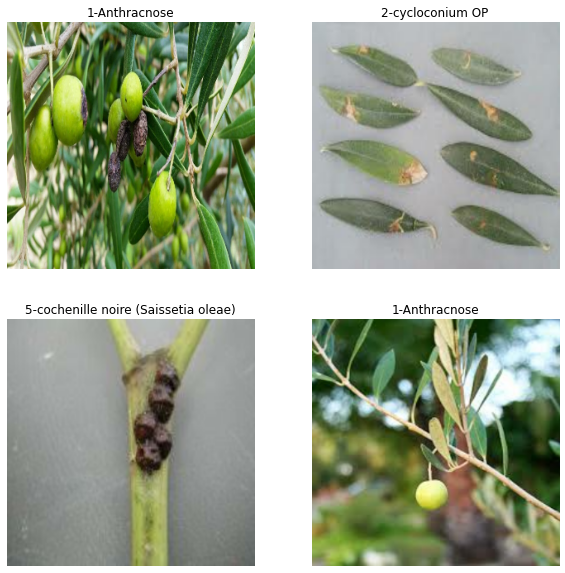

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

28

In [10]:
len(val_ds)

3

In [11]:
len(test_ds)

5

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

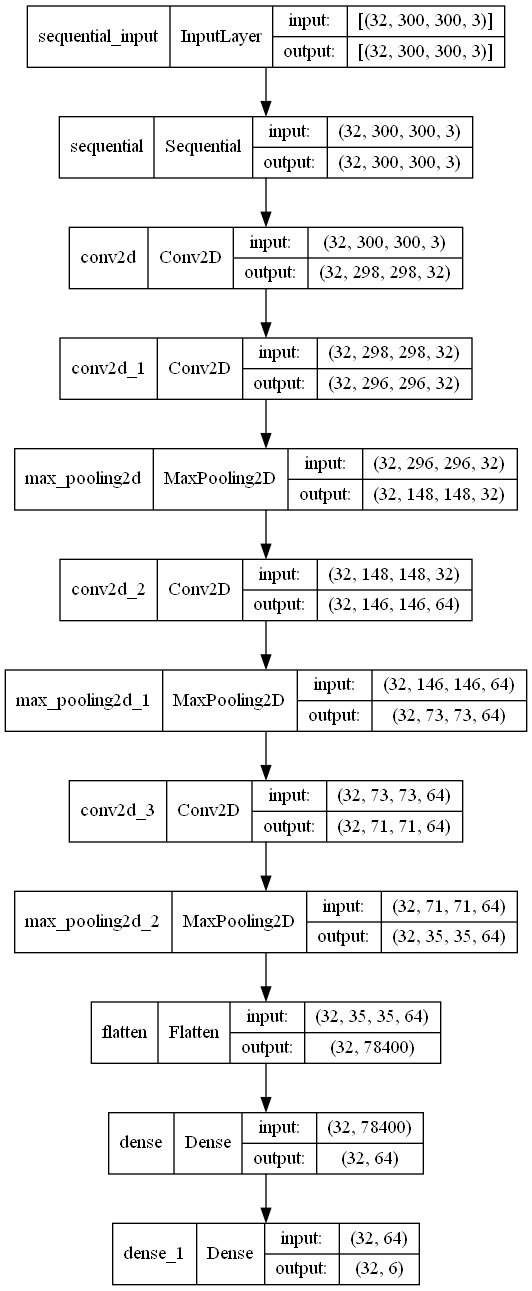

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='graphe.png', show_shapes=True)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 300, 300, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 298, 298, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (32, 296, 296, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 148, 148, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (32, 146, 146, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 73, 73, 64)         0         
 2D)                                                  

#### Compiling the Model

In [19]:
model.compile(
    optimizer='adamax',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/100
28/28 [==============================] - 124s 4s/step - loss: 1.6903 - accuracy: 0.4085 - val_loss: 1.5434 - val_accuracy: 0.4479
Epoch 2/100
28/28 [==============================] - 117s 4s/step - loss: 1.4471 - accuracy: 0.4643 - val_loss: 1.3575 - val_accuracy: 0.5104
Epoch 3/100
28/28 [==============================] - 112s 4s/step - loss: 1.3972 - accuracy: 0.4799 - val_loss: 1.3961 - val_accuracy: 0.4688
Epoch 4/100
28/28 [==============================] - 106s 4s/step - loss: 1.3347 - accuracy: 0.4944 - val_loss: 1.3283 - val_accuracy: 0.4792
Epoch 5/100
28/28 [==============================] - 100s 4s/step - loss: 1.2728 - accuracy: 0.5022 - val_loss: 1.2051 - val_accuracy: 0.5104
Epoch 6/100
28/28 [==============================] - 102s 4s/step - loss: 1.2173 - accuracy: 0.5223 - val_loss: 1.2929 - val_accuracy: 0.5000
Epoch 7/100
28/28 [==============================] - 101s 4s/step - loss: 1.1975 - accuracy: 0.5279 - val_loss: 1.2606 - val_accuracy: 0.5312
Epoch 

28/28 [==============================] - 122s 4s/step - loss: 0.4087 - accuracy: 0.8549 - val_loss: 0.7383 - val_accuracy: 0.8021
Epoch 59/100
28/28 [==============================] - 115s 4s/step - loss: 0.4185 - accuracy: 0.8527 - val_loss: 0.7263 - val_accuracy: 0.8333
Epoch 60/100
28/28 [==============================] - 118s 4s/step - loss: 0.3949 - accuracy: 0.8583 - val_loss: 0.7974 - val_accuracy: 0.8021
Epoch 61/100
28/28 [==============================] - 120s 4s/step - loss: 0.4071 - accuracy: 0.8538 - val_loss: 0.7502 - val_accuracy: 0.8333
Epoch 62/100
28/28 [==============================] - 112s 4s/step - loss: 0.4147 - accuracy: 0.8527 - val_loss: 0.9012 - val_accuracy: 0.7812
Epoch 63/100
28/28 [==============================] - 110s 4s/step - loss: 0.3753 - accuracy: 0.8661 - val_loss: 0.6440 - val_accuracy: 0.8542
Epoch 64/100
28/28 [==============================] - 115s 4s/step - loss: 0.3923 - accuracy: 0.8638 - val_loss: 0.8435 - val_accuracy: 0.8021
Epoch 65/100

In [21]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 6s 621ms/step - loss: 0.5436 - accuracy: 0.8875


In [22]:
scores

[0.5435571670532227, 0.887499988079071]

### Plotting the Accuracy and Loss Curves

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 28}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
type(history.history['loss'])

list

In [27]:
len(history.history['loss'])

100

In [28]:
history.history['loss'][:10]

[1.690253496170044,
 1.447059988975525,
 1.3971799612045288,
 1.3346914052963257,
 1.2728211879730225,
 1.2172750234603882,
 1.1974928379058838,
 1.1668307781219482,
 1.1711769104003906,
 1.1222386360168457]

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

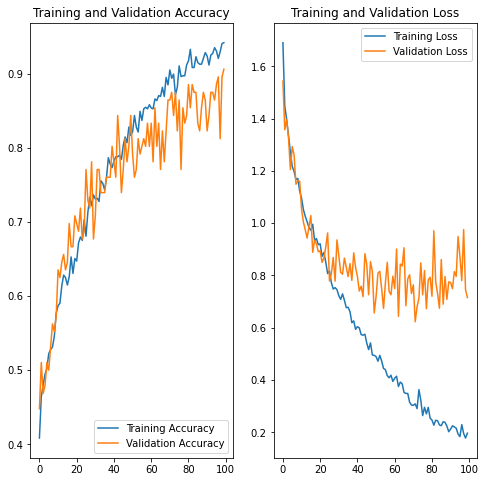

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Run prediction on a sample image

first image to predict
actual label: 2-cycloconium OP
predicted label: 5-cochenille noire (Saissetia oleae)


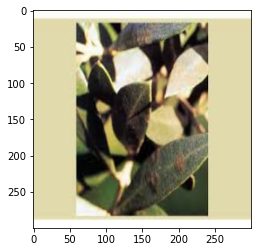

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

#### Write a function for inference

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

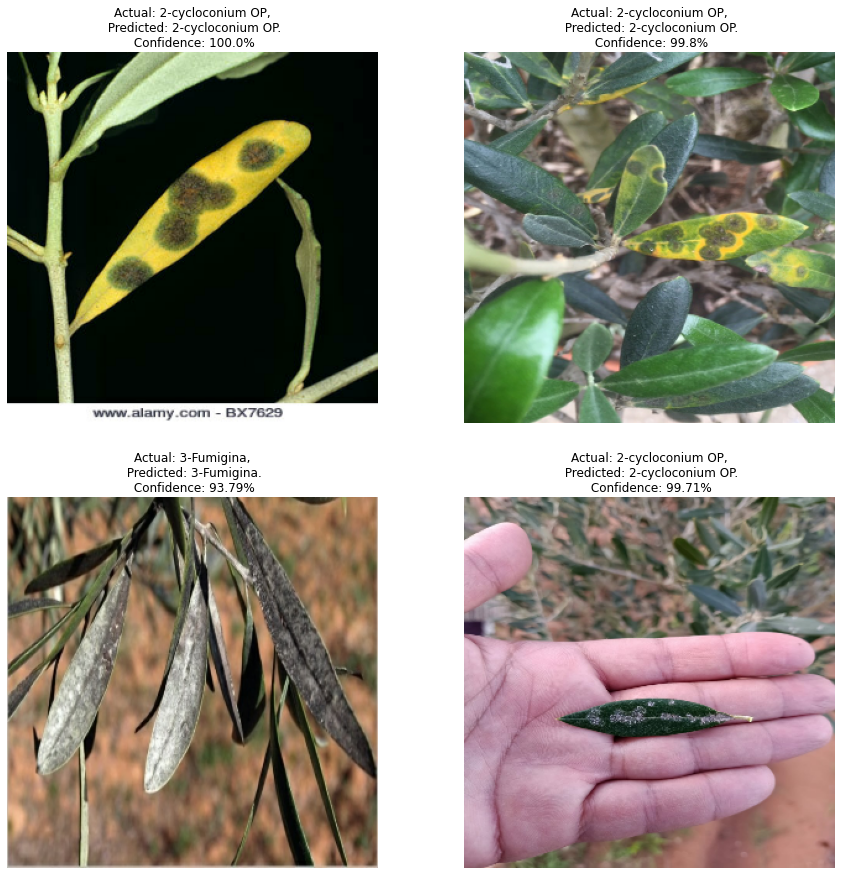

In [33]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Saving the Model

In [34]:
import os
model.save("models/model_oliveaa3.h5")

In [35]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 3s 618ms/step - loss: 0.5436 - accuracy: 0.8875
